 lets follow Fanjin a little more closely
 `/home/dan/usb_twitching/library/core/pnas_Wong_2011_slingshot_motion_observation.pdf`
 the purpose of this is to get a better understanding of analysing
 the trajectory so that we can fully understand how our simulated data
 differs from the experimental data

In [1]:
import os
import sys
import collections
import numpy as np
import _fj
import matplotlib.pyplot as plt
import matplotlib as mpl
import command
import readtrack
import twanalyse 
from tqdm import tqdm



In [2]:
verbose = False
notename = 'fanjin'
notedir = 'fanjin/'
if not os.path.exists(notedir):
	os.makedirs(notedir)
join = os.path.join
def _savefig(name):
	d = os.path.dirname(name)
	if d:
		if not os.path.exists(d):
			os.makedirs(d)
	save = join(notedir,name)
	print("saving to ", save)
	plt.savefig(save)

In [3]:
# ------------------------------------------------------------
idx, ltrs = _fj.slicehelper.load_linearized_trs('all')

100%|██████████| 3113/3113 [00:01<00:00, 2709.50it/s]


In [4]:
crawling_idx = _fj.slicehelper.load('default_crawling_list')
crawling = [ltrs[i] for i in crawling_idx]
candidate_idx = 2924
candidate = ltrs[candidate_idx]
whitelist = _fj.slicehelper.load('candidates_whitelist')
whitelist_tr = [ltrs[i] for i in whitelist]
# ------------------------------------------------------------


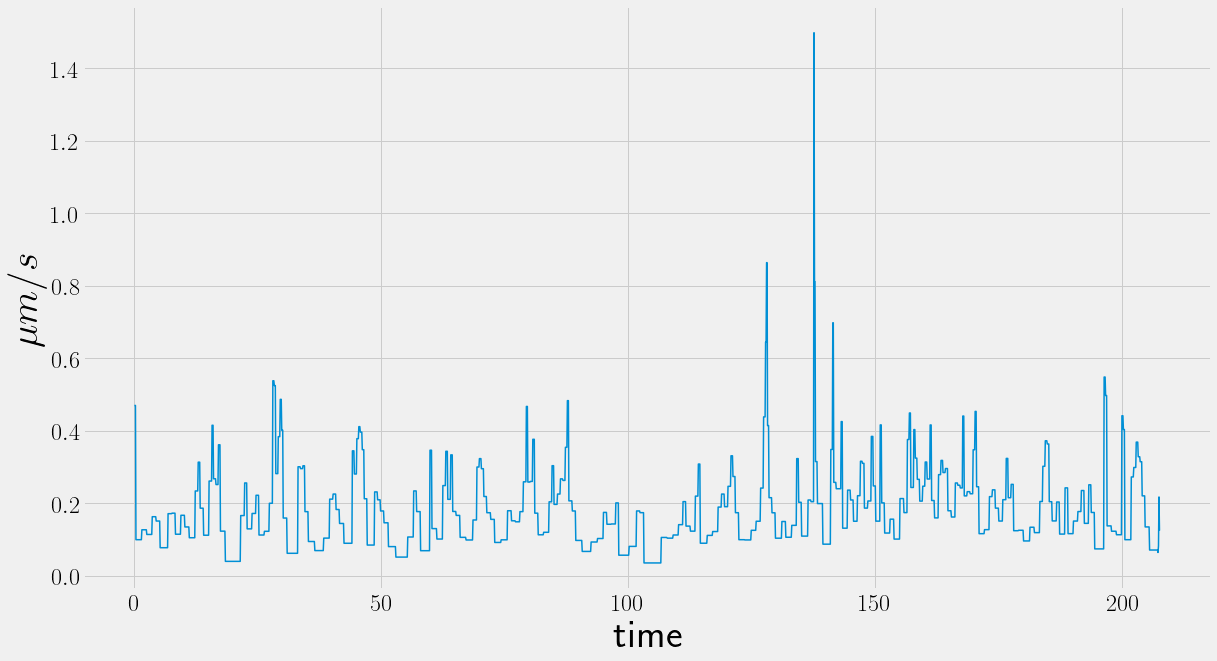

In [5]:
# ------------------------------------------------------------
ax = plt.gca()
def plot_candidate(ax, track):
	time = track['time']
	velocity = track.get_head_v()
	track_speed = np.linalg.norm(velocity, axis=1)
	ax.plot(time[1:]-time[0], track_speed)
	ax.set_xlabel('time')
	ax.set_ylabel('$\mu m/s$')
# plot_candidate(ax, ltrs[10])
plot_candidate(ax, candidate)
plt.show()


 these are linearised tracks,
 lets check that displacements add up to 0.12 $\mu m$

In [6]:
# plot displacement angles, body axis angles 
# for individual linearised trajectories

allpolar = twanalyse.allpolar
plotpolar = twanalyse.plotpolar
def plotpolar_with_axes(polardata):
	fig, axes = plt.subplots(3, 2, subplot_kw=dict(polar=True), 
		figsize=(8,12))
	plotpolar(axes, polardata)



100%|██████████| 1/1 [00:00<00:00, 1305.42it/s]
saving to  fanjin/polar_candidate.png


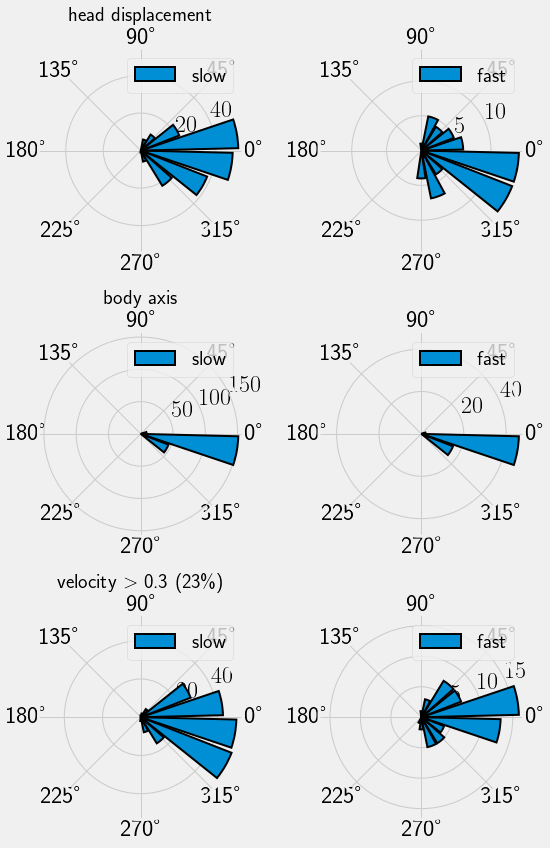

In [7]:
# polar plots for the candidate track only
polardata = allpolar([candidate])
plotpolar_with_axes(polardata)
_savefig("polar_candidate.png")


100%|██████████| 64/64 [00:00<00:00, 3980.30it/s]
saving to  fanjin/polar_whitelist.png


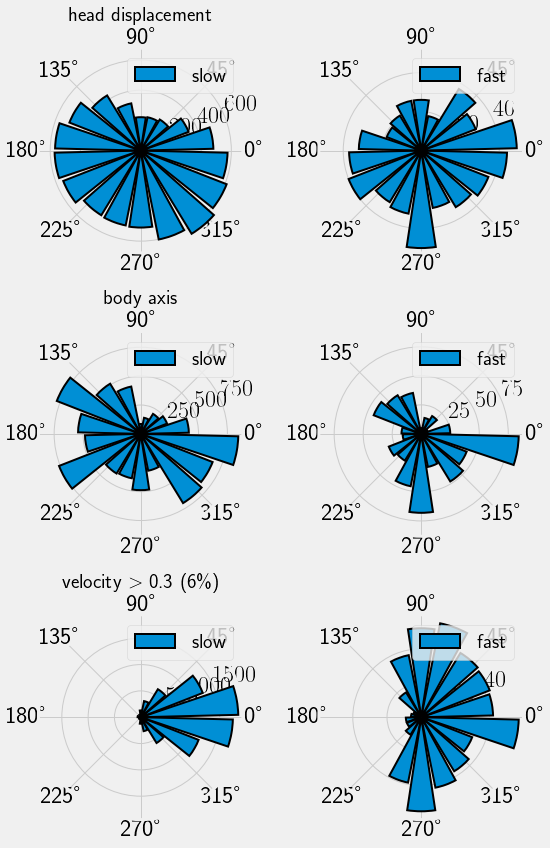

In [8]:
# polar plots for whitelist 
polardata = allpolar(whitelist_tr)
plotpolar_with_axes(polardata)
_savefig("polar_whitelist.png")


100%|██████████| 2505/2505 [00:00<00:00, 2880.64it/s]
saving to  fanjin/polar_crawling.png


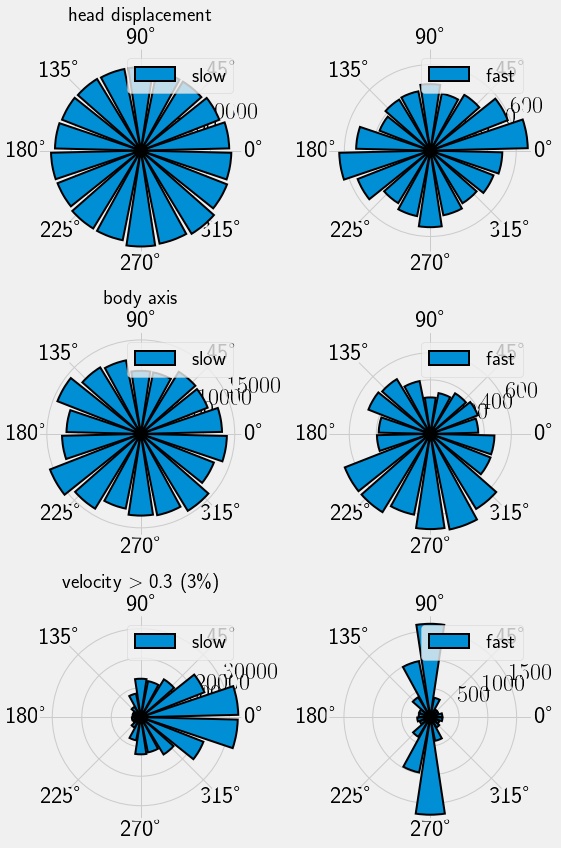

In [9]:
# crawling data
polardata = allpolar(crawling)
plotpolar_with_axes(polardata)
_savefig("polar_crawling.png")


  0%|          | 0/3113 [00:00<?, ?it/s]/home/dan/usb_twitching/pili/src/analysis/twanalyse.py:803: RuntimeWarning: invalid value encountered in true_divide
  norm_dy = dy/np.linalg.norm(dy, axis=1)[:,np.newaxis]
100%|██████████| 3113/3113 [00:01<00:00, 2671.21it/s]
saving to  fanjin/polar_all.png


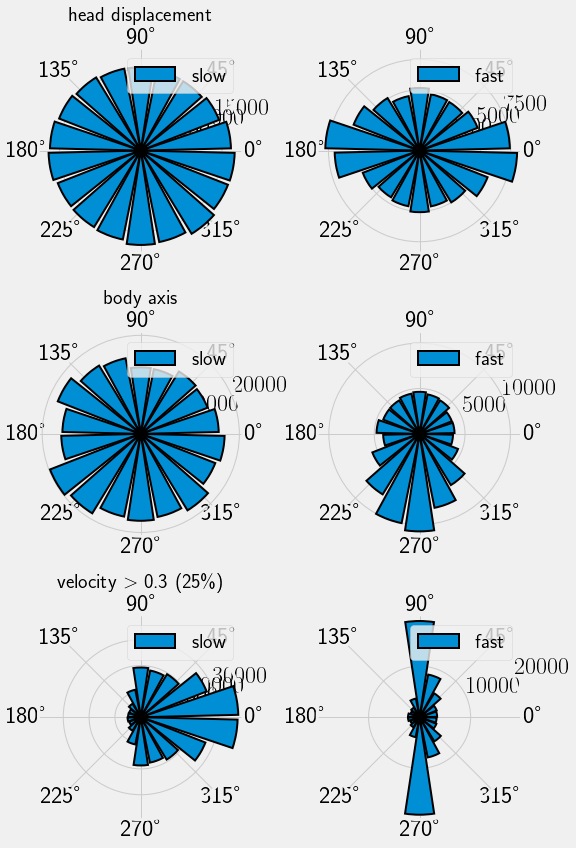

In [10]:
# all data
polardata = allpolar(ltrs)
plotpolar_with_axes(polardata)
_savefig("polar_all.png")


In [11]:
# velocity > 0.3 (25%) ???
# is this a bug in my code or due outliers in the 'all' data
# lets make a walking list with a mean velocity threshold (?)
# see localdir for the removed outliers
localdir = 'vel_outlier'

def velocity_outliers(idx, ltrs, minvel=0.0, maxvel=1.0):
	meanvel = np.array([np.mean(np.linalg.norm(ltr.get_step_velocity(),axis=1)) for ltr in ltrs])
	print(np.isnan(meanvel).shape)
	print(idx.shape)
	nan_idx = idx[np.isnan(meanvel)]
	left_idx = idx[meanvel < minvel]
	right_idx = idx[meanvel > maxvel]
	return left_idx, right_idx, nan_idx
	
left, right, nan = velocity_outliers(idx, ltrs, maxvel=1.0)
bad_idx = np.union1d(right, nan)
l, r, n = left.size, right.size, nan.size
print('left\t{:4d}\tright{:4d}\tnan{:4d}'.format(l, r, n))
print('so there are {:d} candidates to remove'.format(bad_idx.size))

if verbose:
	import shapeplot
	for track_id in right:
		ltrack = ltrs[track_id]
		speed = np.linalg.norm(ltrack.get_step_velocity(), axis=1)
		print('fast step proportion', npcount(speed > 0.3)/speed.size)
		ax = plt.gca()
		shapeplot.longtracks(ax,[ltrack])
		name = join(localdir,'lt_{:04d}.png')
		_savefig(name.format(track_id))
		ax.clear()
	plt.close()

safeall = np.delete(idx, bad_idx)


(3113,)
(3113,)
left	   0	right  30	nan   6
so there are 36 candidates to remove
/home/dan/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dan/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


100%|██████████| 3077/3077 [00:01<00:00, 2943.91it/s]
saving to  fanjin/polar_all.png


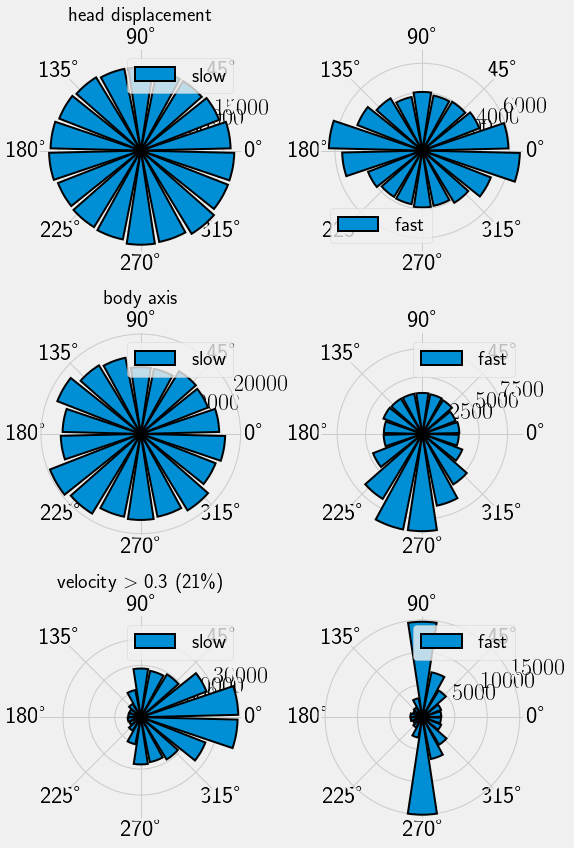

In [12]:

polardata = allpolar([ltrs[i] for i in safeall])
plotpolar_with_axes(polardata)
_savefig("polar_all.png")
# and the value did change from 25% to 21% but its still huge
# compared to the crawling set, need more work to see if 
# high speed individuals in walking set are well resolved or not.




In [13]:
# * candidate trajectory, all polar plots are oriented towards direction of motion
# * whitelist, slow actions are polarised, fast actions have large components in forward direction
#   and also at 90 degrees
# * all tracks, the deviation angle for the fast mode are now dominated by
#   90 degree rotations, so these are associated with slower moving trajectories


searching for tracks with form data/bacterium_*.dat


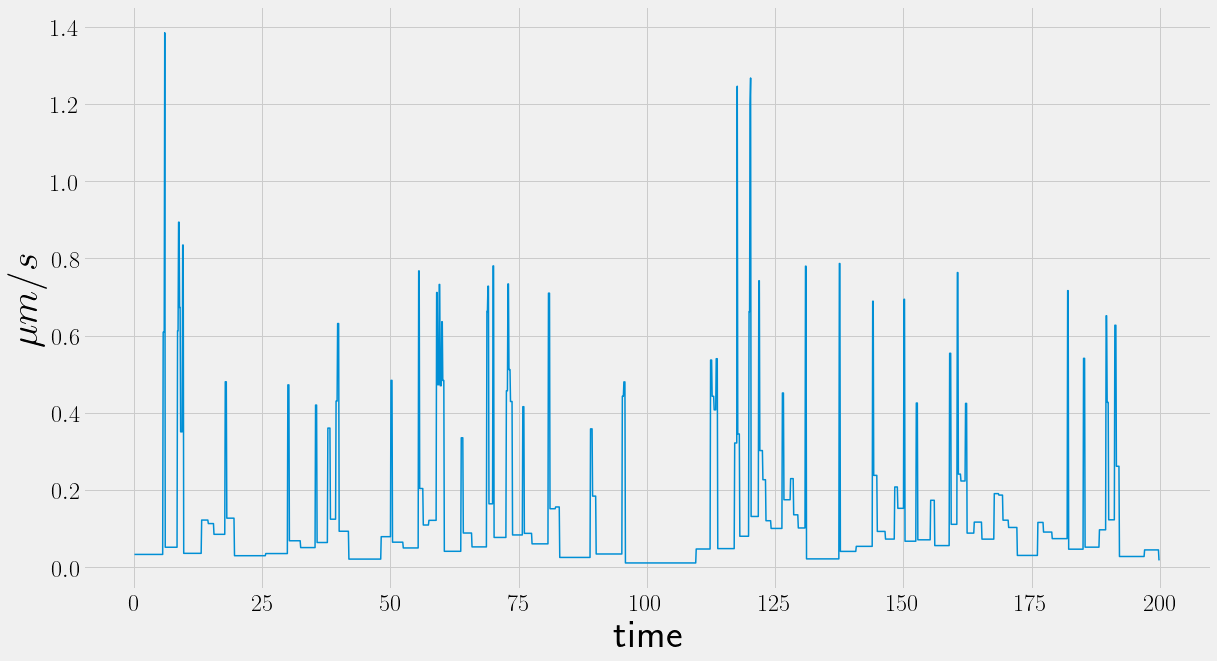

In [14]:
# ------------------------------------------------------------
# lets do the same on simulation dataset
simdir = "/home/dan/usb_twitching/run/new/angle_smoothed/range_pbrf/anchor_angle_smoothing_fraction_00.250"
with command.chdir(simdir):
	simtrs = readtrack.trackset()
sim_ltrs = [_fj.linearize(tr) for tr in simtrs]
simtr = sim_ltrs[0]

plot_candidate(plt.gca(), simtr.part(0,2000))


100%|██████████| 1/1 [00:00<00:00, 589.34it/s]


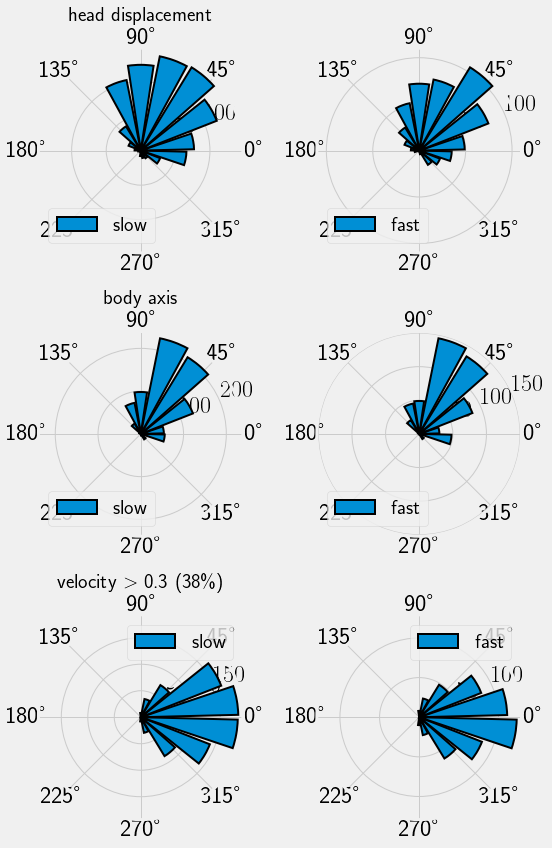

In [15]:
# simulated data 
polardata = allpolar(sim_ltrs)
plotpolar_with_axes(polardata)


 which is similar to candidate. but note that there is not
  much to distinguish fast and slow.

100%|██████████| 1/1 [00:00<00:00, 579.32it/s]


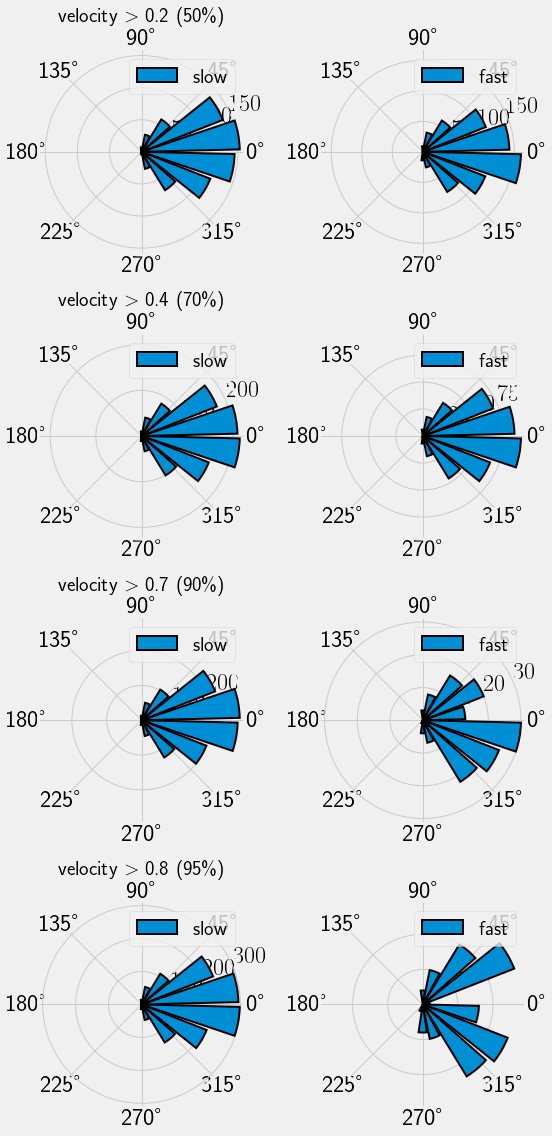

In [16]:
# what about using a different velocity thresold?
# can we see a difference between fast and slow then?
vthreshold = 0.3
quantiles = [0.5, 0.7, 0.9, 0.95]
actdata = twanalyse.actions(sim_ltrs)
def fraction(x, threshold):
	npcount = np.count_nonzero
	return npcount(x>threshold)/x.size

N = len(quantiles)
fig, axes = plt.subplots(N, 2, subplot_kw=dict(polar=True), 
	figsize=(8,4*N))
for i, q in enumerate(quantiles):
	quant = np.quantile(actdata['velocity'], q)
	row = axes[i]
	pdata = twanalyse.allpolar(sim_ltrs, quant)
	fastidx = actdata['velocity'] > quant
	twanalyse.polar_dev(row, pdata.deviation, fastidx)
	row[0].set_title(r'velocity $>$ {:3.1f} ({:d}\%)'.format(
		quant, int(100*q)
	))
	plt.tight_layout()
	

In [17]:
candidate_action = twanalyse.actions([candidate])


100%|██████████| 1/1 [00:00<00:00, 3435.14it/s]


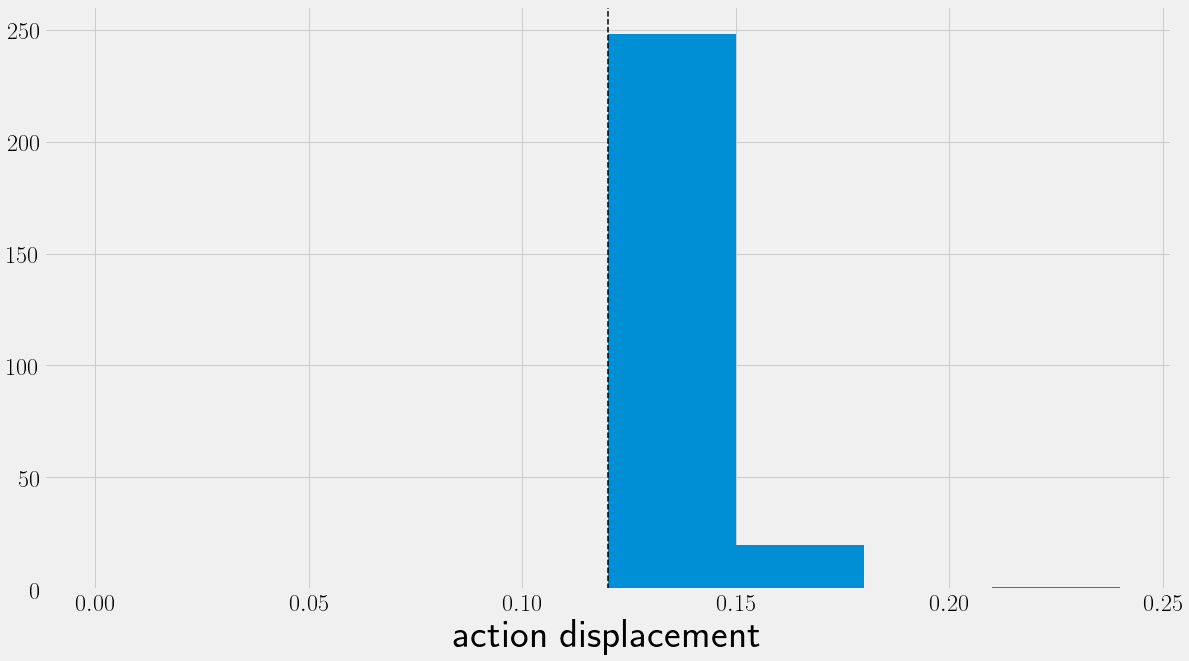

In [18]:
# plot candidate displacements
ax =plt.gca()
bins = np.arange(0,max(candidate_action['dx']),0.03)
ax.hist(candidate_action['dx'], bins=bins)
ax.set_xlabel('action displacement')
ax.axvline(0.12, linestyle='--', color='k')


(array([ 61., 101.,  68.,  24.,   7.,   5.,   2.,   0.,   1.,   1.]),
 array([0.1 , 0.44, 0.78, 1.12, 1.46, 1.8 , 2.14, 2.48, 2.82, 3.16, 3.5 ]),
 <BarContainer object of 10 artists>)

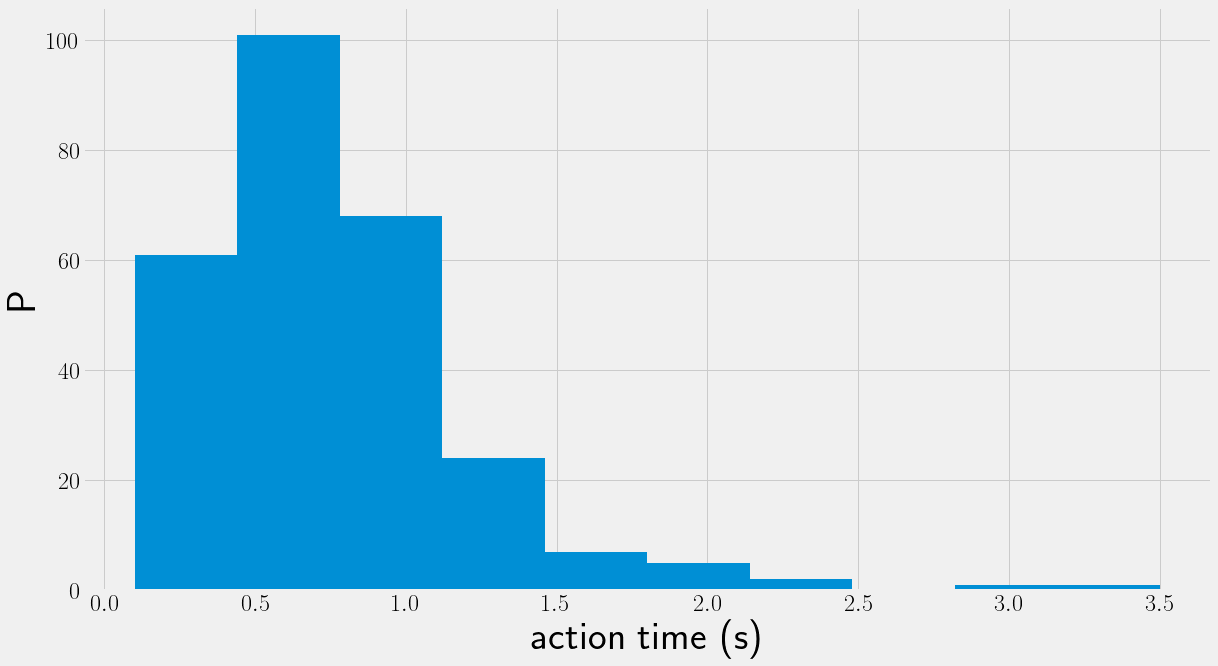

In [19]:
# plot candidate action dt
ax =plt.gca()
ax.set_ylabel('P')
ax.set_xlabel('action time (s)')
ax.hist(candidate_action['dt'])


In [20]:
actions = twanalyse.actions
plot_actiondata = twanalyse.plot_actiondata
candidate_action = actions([candidate])
traction = actions(crawling)


100%|██████████| 2505/2505 [00:00<00:00, 22919.99it/s]


trimming 0.0 elements < 0 && 0.0 elements > 100
trimming 0.0 elements < 0 && 0.0 elements > 100
saving to  fanjin/candidate_actions.png


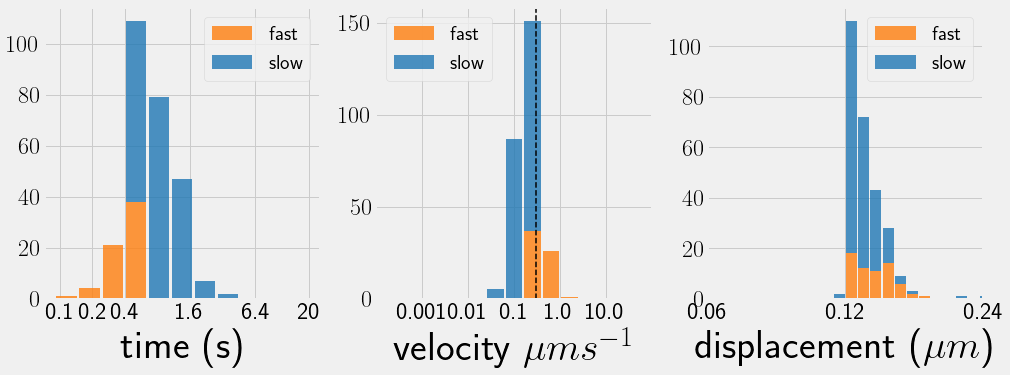

In [21]:
plot_actiondata(candidate_action)
_savefig('candidate_actions.png')
plt.show()


In [22]:
# all data 
if verbose:
	plot_actiondata(traction)
	_savefig('actions.png')
	plt.show()


In [23]:
# [markdown]
# find out where the 0.1/0.2 second fast actions are hiding, look at those trajectories by eye.


trimming 0.0 elements < 0.004 && 0.0 elements > 16
bins [ 0.004  0.007  0.012  0.022  0.038  0.067  0.118  0.207  0.363  0.638
  1.122  1.971  3.463  6.084 10.689 18.782 33.   ]


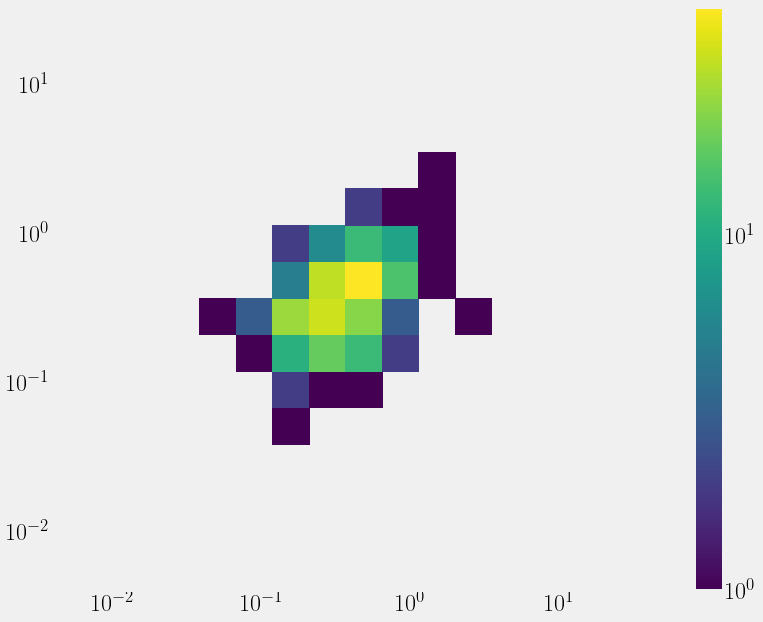

In [24]:
# plot 2d histogram for actions A,A+1

def action_corr(actions):
	# first bin all the actions but keep track of which bin they belong to
	vel = actions['velocity']
	vel = twanalyse.trim_limits(vel, [0.004,16])
	bins = np.geomspace(0.004,33,16+1,True)
	with np.printoptions(precision=3, suppress=True):
		print('bins', bins)
	bincount = np.zeros(bins.size-1,dtype=int) # one less bin than edge
	binmap = [] 
	nbin = []
	count2d = np.zeros((bins.size-1,bins.size-1), dtype=int)
	for i in range(vel.size-1):
		v = vel[i]
		v_n = vel[i+1]
		bin_idx = np.searchsorted(bins, v)
		nbin_idx = np.searchsorted(bins, v_n)
		binmap.append(bin_idx)
		nbin.append(nbin_idx)
		bincount[bin_idx] += 1
		count2d[bin_idx][nbin_idx] += 1
	
	X = bins
	Y = bins
	return X, Y, count2d

X, Y, count2d = action_corr(candidate_action)
def plot_c2d(X, Y, count2d):
	ax = plt.gca()
	ax.set_xscale('log')
	ax.set_yscale('log')
	cmap = mpl.cm.get_cmap()
	cmlist = [cmap(c) for c in np.linspace(0,1,100,True)]
	cm = mpl.colors.LinearSegmentedColormap.from_list('adj', cmlist)
	Im = np.ma.masked_where(count2d == 0, count2d)
	# norm = mpl.colors.Normalize(count2d.min(), count2d.max())
	norm = mpl.colors.LogNorm(1.0, count2d.max())
	pos = plt.pcolormesh(X, Y, Im, cmap=cm, norm=norm)
	plt.colorbar(pos)
	ax.set_aspect('equal')
plot_c2d(X, Y, count2d)


trimming 0.04453258316860121 elements < 0.004 && 4.223900518694984e-06 elements > 16
bins [ 0.004  0.007  0.012  0.022  0.038  0.067  0.118  0.207  0.363  0.638
  1.122  1.971  3.463  6.084 10.689 18.782 33.   ]


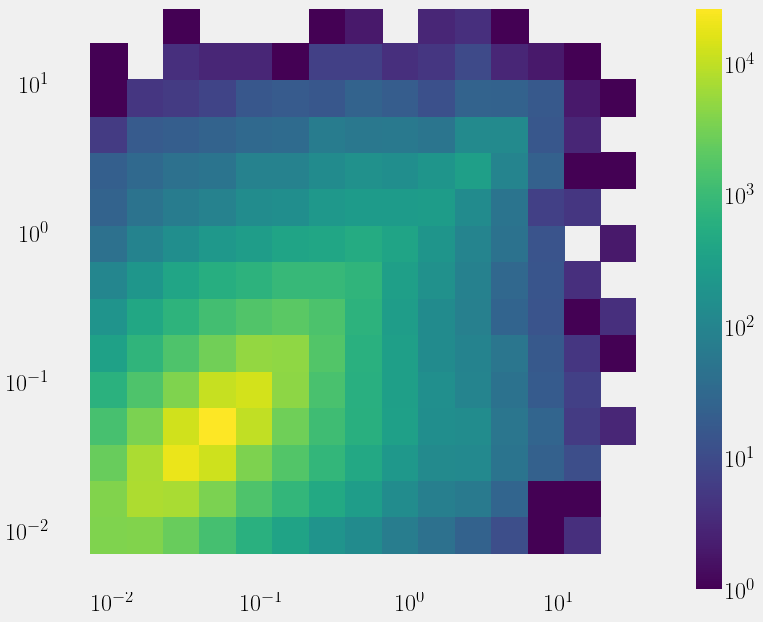

In [25]:
X, Y, c2d = action_corr(traction)
plot_c2d(X, Y, c2d)

